In [57]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mesaPlot as mp
import pandas as pd
import pprint
import csv
import pickle
import multiprocessing
from mint_general_interpolation_grid_builder.functions_natalie.custom_mpl_settings import (
    load_mpl_rc,
)
load_mpl_rc()
cmap = plt.get_cmap('viridis')
m = mp.MESA()


from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.MS_table_builder import MainSequenceTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.GB_table_builder import RedGiantBranchTableBuilder
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.CHeB_table_builder import (
    CoreHeliumBurningTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.src.MINT_table_builders.EAGB_table_builder import (
    EarlyAsymptoticGiantBranchTableBuilder,
)
from mint_general_interpolation_grid_builder.MINT.config.table_columns import table_columns


evol_phase = 'GB'

settings = {
    **table_columns,
    'grid_directory':f'/Users/natalierees/MINT_grids_23051/Z0.02/{evol_phase}',
    'metallicity':0.02,
    'num_processes':4
}

if evol_phase == 'MS':
    tester = MainSequenceTableBuilder(settings=settings)
elif evol_phase == 'GB':
    tester = RedGiantBranchTableBuilder(settings=settings)
elif evol_phase == 'CHeB':
    tester = CoreHeliumBurningTableBuilder(settings=settings)
elif evol_phase == 'EAGB':
    tester = EarlyAsymptoticGiantBranchTableBuilder(settings=settings)

Building a grid with (X_0, Y_0, Z_0)=(0.7, 0.28, 0.02)


198
103


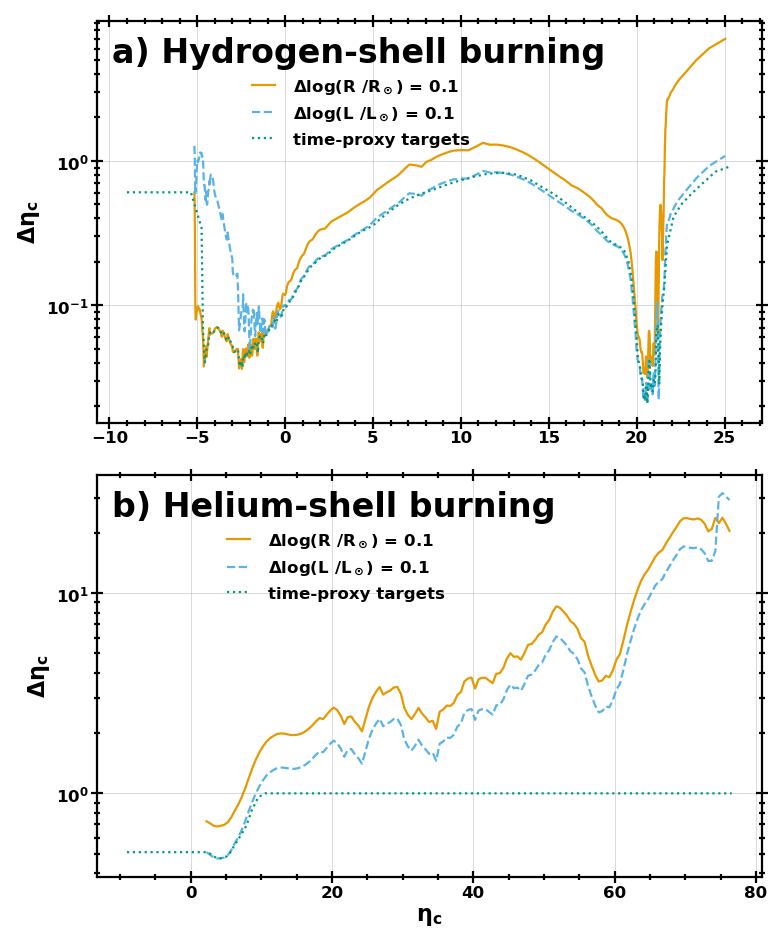

In [63]:
def calc_time_proxy_resolution(
        df,
        tp_name = 'CENTRAL_DEGENERACY',
        q_name = 'LOG_RADIUS',
        delta_target = 0.05,
        ):
    
    df_dq_dtp = pd.DataFrame(columns = np.sort(df[tp_name].unique()))
    for M in df['MASS'].unique()[:]:
        df_M = df[df['MASS']==M]
        for Mi in df_M['INITIAL_MASS'].unique():
            track = df_M[df_M['INITIAL_MASS']==Mi]
            track.drop_duplicates([tp_name],inplace=True)
            dq_dtp = np.abs(np.gradient(track[q_name],track[tp_name]))
            series_to_add = pd.Series(dq_dtp, index=list(track[tp_name].values))
            df_dq_dtp = df_dq_dtp.append(series_to_add, ignore_index=True)


    df_dq_dtp.loc['deta'] = delta_target/np.nanmax(df_dq_dtp,axis=0).astype(float)
    allowed_deta = df_dq_dtp.loc['deta'].rolling(window=10).mean().dropna().sort_index()

    return allowed_deta


# def calc_deta(x,q_name='LOG_RADIUS',tp_name = 'CENTRAL_DEGENERACY',delta_target = 0.05):
#     if len(x) > 1:
#         return delta_target/np.abs(np.gradient(x[q_name],x[tp_name]))
    
# def calc_time_proxy_resolution(
#         df,
#         tp_name = 'CENTRAL_DEGENERACY',
#         q_name = 'LOG_RADIUS',
#         delta_target = 0.05,
#         quantile = 0.1
#         ):
#     allowed_deta = df.groupby(['MASS','INITIAL_MASS']).apply(lambda x: calc_deta(x,q_name,tp_name,delta_target))
#     allowed_deta = pd.DataFrame(allowed_deta,columns=['Values'])['Values'].apply(pd.Series).quantile(quantile)
#     allowed_deta.index = df[tp_name].unique()
#     return allowed_deta.rolling(window=10).mean().dropna().sort_index()

def get_degen_targets(evol_phase, allowed_deta, first_target, max_allowed_deta = 0.5):

    # INTEGRATE DEGENERACY ARRAY
    degen_targets = [first_target]
    while degen_targets[-1] < allowed_deta.index.max():
        deta = allowed_deta.values[np.argmin(abs(allowed_deta.index-degen_targets[-1]))]
        deta = min(deta,max_allowed_deta)
        degen_targets += [round(degen_targets[-1]+deta,6)]

    print(len(degen_targets))
    if len(degen_targets) != len(set(degen_targets)):
        raise ValueError('DUPLICATE DEGEN TARGETS')
    
    save_targets_file_path = f'/Users/natalierees/mint_general_interpolation_grid_builder/MINT/config/time_proxy_targets/{evol_phase}.py'
    import json
    with open(save_targets_file_path, 'w') as f:
        f.write('targets = ')
        json.dump(degen_targets, f, indent=2) 
    
    return degen_targets


fig,ax=plt.subplots(2,1,figsize=(10,12))

delta_target_dict = {'LOG_RADIUS':0.1,'LOG_LUMINOSITY':0.1}
label_dict = {'LOG_RADIUS':r'$\Delta \log (R~/\mathrm{R}_\odot)$ = ',
              'LOG_LUMINOSITY':r'$\Delta \log (L~/\mathrm{L}_\odot)$ = ',}

for i, evol_phase in enumerate(['GB','EAGB']):

    allowed_deta_list = []
    df = tester.load_table(evol_phase)

    for quantity, delta_target in delta_target_dict.items():

        allowed_deta = calc_time_proxy_resolution(
            df=df[(df['MASS']==df['INITIAL_MASS'])],
            q_name = quantity,
            delta_target=delta_target
            )
        allowed_deta_list += [allowed_deta]
        ax[i].plot(allowed_deta.index,(allowed_deta.values),label=label_dict[quantity]+f'{delta_target}')

    allowed_deta = pd.concat(allowed_deta_list, axis=1).min(axis=1)
    targets = get_degen_targets(
        evol_phase=evol_phase, 
        allowed_deta = allowed_deta, 
        first_target = -9.0, 
        max_allowed_deta = 1.0
        )
    ax[i].plot(targets,(np.gradient(targets)),label='time-proxy targets')

    ax[i].set_yscale('log')


# EAGB_targets = get_degen_targets('EAGB', delta_target = delta_target)
# ax.scatter(EAGB_targets,np.log10(np.gradient(EAGB_targets)),label='helium-shell burning')

# ax[0].set_ylim(-3,1)
ax[0].legend(title='a) Hydrogen-shell burning')
ax[1].legend(title='b) Helium-shell burning')
ax[1].set(xlabel=r'$\eta_\mathrm{c}$',ylabel=r'$\Delta \eta_\mathrm{c}$')
ax[0].set(ylabel=r'$\Delta \eta_\mathrm{c}$')

fig.tight_layout()
plt.savefig(f'plots/degen_resolution.jpeg',dpi=200)


In [62]:
    common_save_targets = np.intersect1d(
        [1,2], [3]
    )
    common_save_targets
    common_save_targets = np.delete(
        common_save_targets, np.where(common_save_targets == 0)
    )